In [14]:
import numpy as np
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.autograd import Function
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
DEVICE = get_default_device()
print(DEVICE)

cuda


In [16]:
def switch_to_device(dataset, device = None):
    tensor_list_x, tensor_list_y = [], []

    for x, y in dataset:
        tensor_list_x.append(x)
        tensor_list_y.append(y)
    
    X = torch.stack(tensor_list_x)
    Y = torch.tensor(tensor_list_y)

    if DEVICE is not None:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
    
    return torch.utils.data.TensorDataset(X, Y)

In [17]:
def get_mnist_dl(batch_size_train = 1024, batch_size_valid = 1024, device = None):
    transform = transforms.Compose([transforms.ToTensor()])

    data_train = torchvision.datasets.MNIST('./mnist', train = True, download = True, transform = transform)
    data_train = switch_to_device(data_train, device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000, 5000])

    data_test = torchvision.datasets.MNIST('./mnist', train = False, download = True, transform = transform)
    data_test = switch_to_device(data_test, device)

    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_valid, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_valid, shuffle=False)

    return train_dl, valid_dl, test_dl

In [18]:
def Binarize(x, quant_mode = 'det'):
    if quant_mode == 'det':
        return x.sign()
    else:
        return x.add_(1).div_(2).add_(torch.rand(x.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

In [19]:
def Quantized(x):
    return torch.round(x)

In [20]:
class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
        self.margin = 1.0

    def hingeloss(self, input, target):
        #input : batchsize*1
        #target: batchsize*1
        output = self.margin - input.mul(target)
        output[output.le(0)] = 0
        return torch.mean(output)

    def forward(self, input, target):
        return self.hingeloss(input, target)


In [21]:
class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):
        
        if input.size(1) != 784:
            input.data=Binarize(input.data)
        
        
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)

        if not self.bias is None:
            if not hasattr(self.bias,'org'):
                self.bias.org=self.bias.data.clone()
            self.bias.data = Binarize(self.bias.org)
            out += self.bias.view(1, -1).expand_as(out)

        return out
    
    def return_param(self):
        if self.bias is None:
            return self.weight.view(1, -1)
        else:
            return torch.cat((self.weight.T.reshape(1, -1), self.bias.reshape(1, -1)), 1)

In [22]:
class BMLP(nn.Module):
    def __init__(self):
        super(BMLP, self).__init__()
        self.fc_1 = BinarizeLinear(28*28, 1024, bias = True, device = DEVICE)
        self.htan_1 = nn.Hardtanh()
        #self.htan_1 = nn.ReLU()
        self.bn_1 = nn.BatchNorm1d(1024, device = DEVICE)

        self.fc_2 = BinarizeLinear(1024, 1024, bias = True, device = DEVICE)
        self.htan_2 = nn.Hardtanh()
        #self.htan_2 = nn.ReLU()
        self.bn_2 = nn.BatchNorm1d(1024, device = DEVICE)

        self.fc_3 = BinarizeLinear(1024, 1024, bias = True, device = DEVICE)
        self.htan_3 = nn.Hardtanh()
        #self.htan_3 = nn.ReLU()
        self.bn_3 = nn.BatchNorm1d(1024, device = DEVICE)
        
        self.fc_4 = BinarizeLinear(1024, 10, bias = True, device = DEVICE)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.5)

    
    def forward(self, input):
        x = torch.reshape(input, (input.shape[0], 28*28))
        #x = torch.matmul(x, self.down_sample.T)
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.htan_1(x)
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.htan_2(x)
        x = self.fc_3(x)
        x = self.bn_3(x)
        x = self.htan_3(x)
        x = self.fc_4(x)
        #return self.softmax(x)
        return x
    
    def return_param(self):
        return torch.cat((self.fc_1.return_param(), self.fc_2.return_param(), self.fc_3.return_param(), self.fc_4.return_param()), 1)


In [23]:
def print_stats(stats):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (7, 3), dpi = 110)
    ax1.grid()
    ax2.grid()

    ax1.set_title("ERM loss")
    ax2.set_title("Valid Acc")

    ax1.set_xlabel("iterations")
    ax2.set_xlabel("iterations")

    itrs = [x[0] for x in stats['train-loss']]
    loss = [x[1].cpu().detach().numpy() for x in stats['train-loss']]
    ax1.plot(itrs, loss)

    itrs = [x[0] for x in stats['valid-acc']]
    acc = [x[1] for x in stats['valid-acc']]
    ax2.plot(itrs, acc)

    ax1.set_ylim(0.0, np.max(loss))
    ax2.set_ylim(0.0, 1.05)

In [24]:
@torch.no_grad()
def get_acc(model, dl, device = DEVICE):
    acc = []

    for X, y in dl:
        #y = y//2
        #one_hot_y = torch.zeros(X.shape[0], 5).to(device)
        #one_hot_y[[i for i in range(X.shape[0])], [k.item() for k in y]] = 1
        res = model.forward(X)
        acc.append(torch.argmax(res, dim = 1) == y)

    acc = torch.cat(acc)
    acc = torch.sum(acc)/len(acc)

    return acc.item()

In [25]:
def run_experiment(model, train_dl, valid_dl, test_dl, optimizer, scheduler, softweight_flag, trick_flag, criterion, max_epochs = 20, device = DEVICE):
    itr = -1
    stats = {'train-loss' : [], 'valid-acc' : []}
    model.train()
    accumulation = {}
    change = {}
    for i, p in enumerate(model.parameters()):
        accumulation[i] = torch.zeros(p.data.shape, device = DEVICE)
        change[i] = torch.zeros(p.data.shape, device = DEVICE)
    for epoch in range(max_epochs):
        for X, y in train_dl:
            itr += 1
            X, y = Variable(X), Variable(y)
            #y = y//2
            optimizer.zero_grad()
            res = model.forward(X)
            loss = criterion(res, y)
            stats['train-loss'].append((itr, loss))
            loss.backward()
            
            if softweight_flag:
                for p in list(model.parameters()):
                    if hasattr(p, 'org'):
                        p.data.copy_(p.org)
            elif trick_flag:
                for i, p in enumerate(model.parameters()):
                    if hasattr(p, 'org'):
                        #p.grad = p.grad*10
                        tmp_accumulation = accumulation[i] + p.grad.sign()#.int()
                        tmp_accumulation = tmp_accumulation.clamp_(-16, 16)
                        possible_pos = (tmp_accumulation.sign() == p.grad.sign())
                        accumulation[i] = tmp_accumulation.clone()
                        p.grad = p.grad*torch.abs(tmp_accumulation)*possible_pos
                        p.grad[torch.abs(tmp_accumulation)>15.5]*=100000
                        change[i] = ((p.data.sign()*p.grad)>(1/optimizer.state_dict()['param_groups'][0]['lr']))

            optimizer.step()
            #scheduler.step()
            
            if softweight_flag == False and trick_flag:
                for i, p in enumerate(model.parameters()):
                    if hasattr(p, 'org'):
                        a = (1 - torch.abs(p.data.clamp_(-1, 1)))
                        #b = torch.zeros(p.grad.shape, device = DEVICE)
                        #c = torch.stack((a, b))
                        #accumulation[i] = accumulation[i] * ~change[i] - (accumulation[i] * change[i] * torch.max(c, dim = 0).values).int()
                        #accumulation[i] = accumulation[i] * ~change[i] - (accumulation[i] * change[i] * a).int()
                        accumulation[i] = accumulation[i] * ~change[i]
            

            for p in list(model.parameters()):
                if hasattr(p,'org'):
                    if softweight_flag:
                        p.org.copy_(p.data.clamp_(-1,1))
                    else:
                        p.org.copy_(p.data.sign())
            
            if itr % 20 == 0:
                model.eval()
                valid_acc = get_acc(model, valid_dl, device = device)
                stats['valid-acc'].append((itr, valid_acc))
                s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}"
                print(s)
                model.train()
    
    model.eval()
    test_acc = get_acc(model, test_dl, device=device)
    print(f"[test] acc:{test_acc:.3f}")
    return stats

In [26]:
max_epochs = 100
train_batch = 1024
valid_batch = 1024
lr = 0.1
criterion =nn.CrossEntropyLoss()
model = BMLP()
softweight_flag = False
trick_flag = True
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.5)

0:0 [train] loss:51.535, [valid] acc:0.093
0:20 [train] loss:35.772, [valid] acc:0.468
0:40 [train] loss:7.015, [valid] acc:0.773
1:60 [train] loss:3.161, [valid] acc:0.857
1:80 [train] loss:3.239, [valid] acc:0.894
1:100 [train] loss:1.963, [valid] acc:0.908
2:120 [train] loss:1.802, [valid] acc:0.909
2:140 [train] loss:1.617, [valid] acc:0.936
2:160 [train] loss:1.738, [valid] acc:0.927
3:180 [train] loss:1.395, [valid] acc:0.939
3:200 [train] loss:1.186, [valid] acc:0.939
4:220 [train] loss:0.807, [valid] acc:0.943
4:240 [train] loss:1.197, [valid] acc:0.949
4:260 [train] loss:1.073, [valid] acc:0.948
5:280 [train] loss:0.918, [valid] acc:0.949
5:300 [train] loss:1.335, [valid] acc:0.951
5:320 [train] loss:0.939, [valid] acc:0.952
6:340 [train] loss:0.765, [valid] acc:0.957
6:360 [train] loss:0.768, [valid] acc:0.956
7:380 [train] loss:0.652, [valid] acc:0.958
7:400 [train] loss:0.712, [valid] acc:0.961
7:420 [train] loss:0.790, [valid] acc:0.955
8:440 [train] loss:0.847, [valid] ac

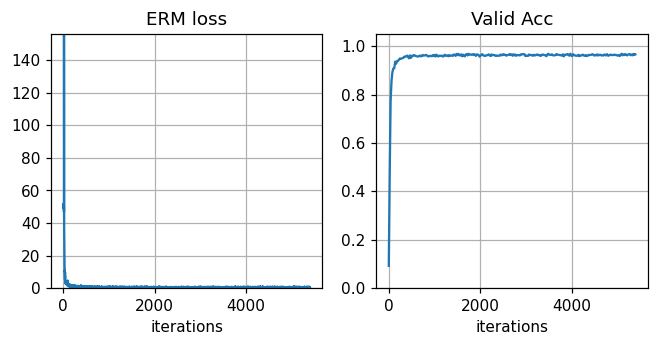

In [27]:
train_dl, valid_dl, test_dl = get_mnist_dl(batch_size_train=train_batch, batch_size_valid=valid_batch, device = DEVICE)
stats = run_experiment(model, train_dl, valid_dl, test_dl, optimizer, scheduler, softweight_flag, trick_flag, criterion, max_epochs=max_epochs, device = DEVICE)
print_stats(stats)

In [28]:
'''
a = model.return_param()
print(a.shape)
torch.save(a, 'Parameters/no_bn_0.05_300.pt')
'''

"\na = model.return_param()\nprint(a.shape)\ntorch.save(a, 'Parameters/no_bn_0.05_300.pt')\n"